In [28]:
!pip install xgboost

In [29]:
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import statistics
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
import xgboost as xgb

In [30]:
loc = '/Users/alonsosalcido/Desktop/Quantifying the World/case 4/data'

In [27]:
year1 = pd.read_csv("D:\\SMUMSDS\\QuantWorld\\CS4\\1year.arff",skiprows=69,header=None,na_values='?')
year2 = pd.read_csv("D:\\SMUMSDS\\QuantWorld\\CS4\\2year.arff",skiprows=69,header=None,na_values='?')
year3 = pd.read_csv("D:\\SMUMSDS\\QuantWorld\\CS4\\3year.arff",skiprows=69,header=None,na_values='?')
year4 = pd.read_csv("D:\\SMUMSDS\\QuantWorld\\CS4\\4year.arff",skiprows=69,header=None,na_values='?')
year5 = pd.read_csv("D:\\SMUMSDS\\QuantWorld\\CS4\\5year.arff",skiprows=69,header=None,na_values='?')
data_labels=pd.read_csv('https://raw.githubusercontent.com/AlonsoSalcido/Quantifying-the-World/main/Data_Labels.csv')
count = 1
for i in [year1,year2,year3,year4,year5]:
    i['year']=count
    count+=1

In [4]:
# Concatenate Tables
data = pd.concat([year1,year2,year3,year4,year5],axis=0,ignore_index=True)
data.columns = data.columns.astype(str)

In [5]:
# Display Data Info with classes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 66 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       43397 non-null  float64
 1   1       43397 non-null  float64
 2   2       43397 non-null  float64
 3   3       43271 non-null  float64
 4   4       43316 non-null  float64
 5   5       43397 non-null  float64
 6   6       43397 non-null  float64
 7   7       43311 non-null  float64
 8   8       43396 non-null  float64
 9   9       43397 non-null  float64
 10  10      43361 non-null  float64
 11  11      43271 non-null  float64
 12  12      43278 non-null  float64
 13  13      43397 non-null  float64
 14  14      43369 non-null  float64
 15  15      43310 non-null  float64
 16  16      43311 non-null  float64
 17  17      43397 non-null  float64
 18  18      43277 non-null  float64
 19  19      43278 non-null  float64
 20  20      37551 non-null  float64
 21  21      43397 non-null  float64
 22

In [6]:
data.head

<bound method NDFrame.head of               0        1         2        3         4        5         6  \
0      0.200550  0.37951  0.396410  2.04720   32.3510  0.38825  0.249760   
1      0.209120  0.49988  0.472250  1.94470   14.7860  0.00000  0.258340   
2      0.248660  0.69592  0.267130  1.55480   -1.1523  0.00000  0.309060   
3      0.081483  0.30734  0.458790  2.49280   51.9520  0.14988  0.092704   
4      0.187320  0.61323  0.229600  1.40630   -7.3128  0.18732  0.187320   
...         ...      ...       ...      ...       ...      ...       ...   
43400  0.012898  0.70621  0.038857  1.17220  -18.9070  0.00000  0.013981   
43401 -0.578050  0.96702 -0.800850  0.16576  -67.3650 -0.57805 -0.578050   
43402 -0.179050  1.25530 -0.275990  0.74554 -120.4400 -0.17905 -0.154930   
43403 -0.108860  0.74394  0.015449  1.08780  -17.0030 -0.10886 -0.109180   
43404 -0.105370  0.53629 -0.045578  0.91478  -56.0680 -0.10537 -0.109940   

             7        8         9  ...        56       57

In [7]:
#Column 64 should be Boolean
data['64'] = data['64'].astype('bool')

## MIssing Values

In [8]:
# Print Data Shape
data.shape

(43405, 66)

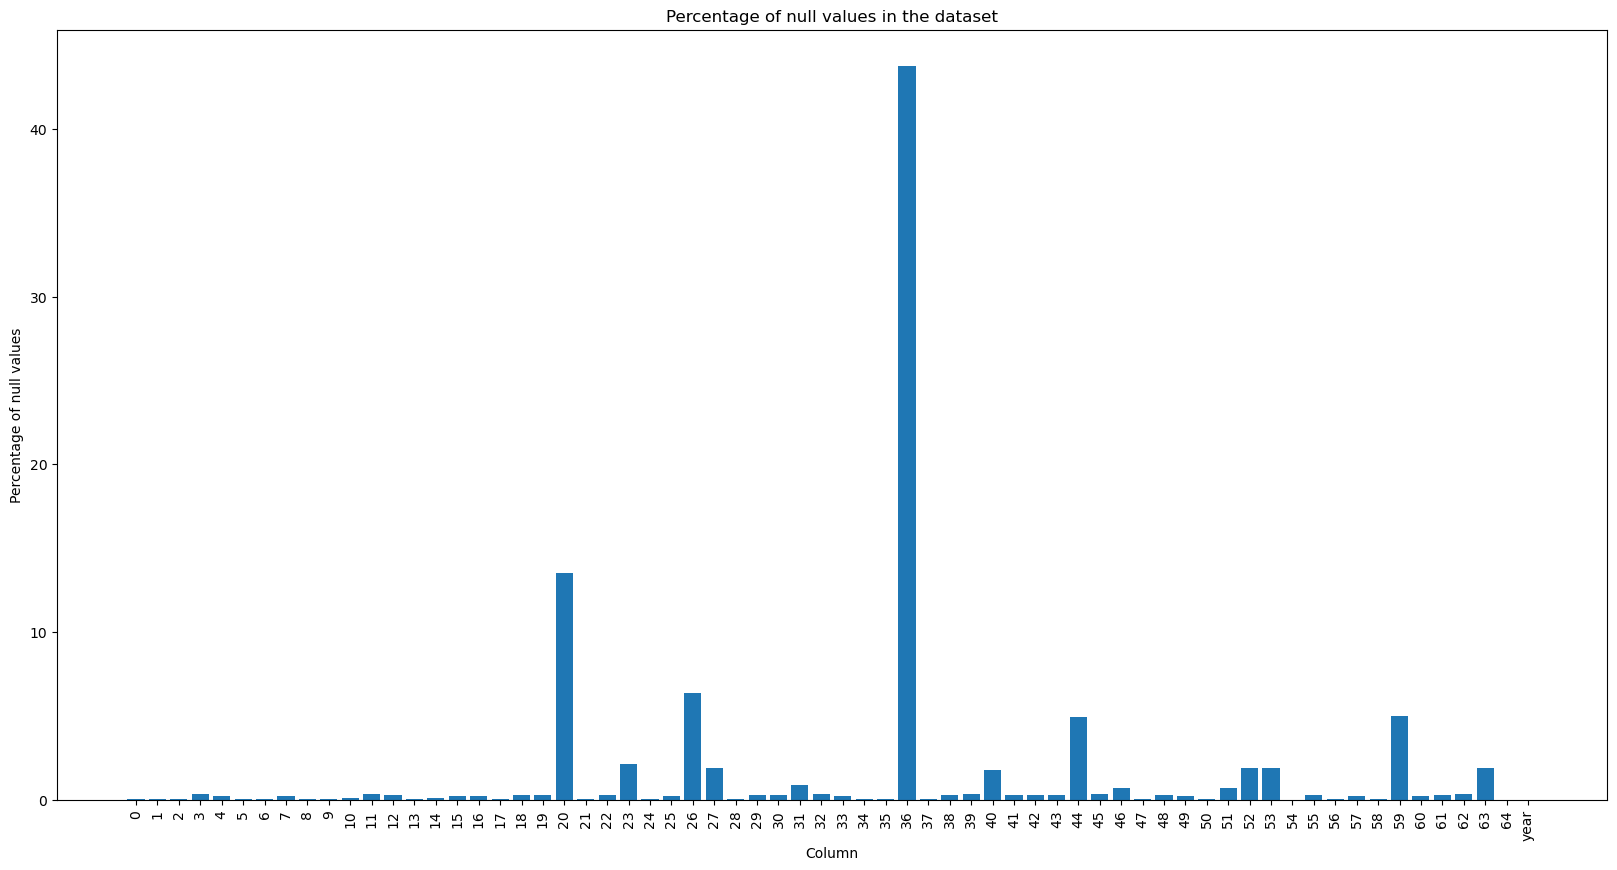

In [9]:
# Calculate the percentage of null values in each column
null_percentages = data.isnull().sum() / len(data) * 100

# Plot the null value percentages
plt.figure(figsize=(20, 10))
plt.bar(null_percentages.index, null_percentages.values)
plt.xticks(rotation=90)
plt.xlabel('Column')
plt.ylabel('Percentage of null values')
plt.title('Percentage of null values in the dataset')
plt.show()

In [10]:
print(data_labels.head(60))

     ID                                        Description
0    X1                          net profit / total assets
1    X2                   total liabilities / total assets
2    X3                     working capital / total assets
3    X4            current assets / short-term liabilities
4    X5  [(cash + short-term securities + receivables -...
5    X6                   retained earnings / total assets
6    X7                                EBIT / total assets
7    X8           book value of equity / total liabilities
8    X9                               sales / total assets
9   X10                              equity / total assets
10  X11  (gross profit + extraordinary items + financia...
11  X12              gross profit / short-term liabilities
12  X13              (gross profit + depreciation) / sales
13  X14           (gross profit + interest) / total assets
14  X15  (total liabilities * 365) / (gross profit + de...
15  X16  (gross profit + depreciation) / total liabiliti

In [11]:
#Print Data Label
print(data_labels.iloc[36]['Description'])

# Print summary statistics for column 36
print(data['36'].describe())

(current assets - inventories) / long-term liabilities
count     24421.000000
mean        105.085363
std        3058.429830
min        -525.520000
25%           1.142300
50%           3.096300
75%          11.414000
max      398920.000000
Name: 36, dtype: float64


In [12]:
train_data = data[data['36'].notnull()]
train_data_x= train_data.iloc[:, :64]
train_data_x= train_data_x.drop(train_data_x.columns[36], axis=1)

In [13]:
# Impute missing data in column '36

# Create KNN imputer object
imputer = KNNImputer(n_neighbors=4)

# Impute missing values in column '36'
imputed_y = imputer.fit_transform(data[['36']])

# Merge imputed '36' values with original dataframe
merged_df = pd.concat([train_data_x, pd.DataFrame(imputed_y, columns=['36'])], axis=1)
data['36']=merged_df['36']

In [14]:
# Print summary statistics for column 36
print(data['36'].describe())

count     43405.000000
mean        105.085363
std        2294.068984
min        -525.520000
25%           2.485300
50%          47.120000
75%         105.085363
max      398920.000000
Name: 36, dtype: float64


In [15]:
dcols=data.iloc[:, :64]
dcols=dcols.drop(dcols.columns[36], axis=1)
cols_to_use = dcols.columns

In [16]:
# create KNN imputer object
imputer = KNNImputer(n_neighbors=4)

# impute missing values using KNN imputer
data[cols_to_use] = imputer.fit_transform(data[cols_to_use])

In [17]:
#Check For Null Values After Imputation

# Count the total null values in the dataset
total_null_count = data.isnull().sum().sum()

print("Data Shape:", data.shape)
print("Total null values in the dataset:", total_null_count)

Data Shape: (43405, 66)
Total null values in the dataset: 0


In [18]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=10, class_weight='balanced')
splits = KFold(n_splits=5,shuffle=True)
cross_val_scores= cross_val_score(rf, data.iloc[:,0:64],data.iloc[:,64], cv=splits, scoring='roc_auc')
print(cross_val_scores)

[0.89314806 0.90054355 0.90283783 0.90259027 0.89920521]


## Grid Search

In [19]:
%%time

parameters = {
    'criterion': ['entropy'],
    'max_depth': [15, 20, 30],
    'min_samples_split': [4,6,8],
    'min_samples_leaf':[2,4,6],
    'max_features': ['log2', 'sqrt'],
    'n_estimators': [100, 200] 
}
search = RandomizedSearchCV(rf,parameters, scoring='roc_auc',cv=splits, n_iter=20)
outcomes = search.fit(data.iloc[:,0:64],data.iloc[:,64],)

Wall time: 14min 35s


In [20]:
print(outcomes.best_score_)
print(outcomes.best_params_)

0.9168022397440933
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'entropy'}


In [34]:
Xtrain,Xtest,ytrain,ytest = train_test_split(data.iloc[:,0:64],data.iloc[:,64],test_size=0.20)

In [35]:
ytrain.shape

(34724,)

In [36]:
train_dm = xgb.DMatrix(Xtrain,label=ytrain)
eval_dm = xgb.DMatrix(Xtest,label=ytest)

In [37]:
params = {'subsample':0.75,
          'max_depth': 4,
          'eval_metric':'auc',
          'objective':'binary:logistic'}

In [21]:
%%time
rf_clf3 = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [25,50,100,200],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [10,15,20],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rf_clf3, param_grid=param_grid, cv= 2,verbose=1)
CV_rfc.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [22]:

# Create an IterativeImputer object with a linear regression model
imputer = IterativeImputer(estimator=LinearRegression(), max_iter=1000)

# Impute missing values using the IterativeImputer
data[cols_to_use] = imputer.fit_transform(data[cols_to_use])

NameError: name 'IterativeImputer' is not defined

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

In [ ]:
######################################
#  How not to Grid Search            #
#  Note how we barely scan the       #
#  range of parameters               #
######################################
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
parameters = {
    'criterion': ['gini','entropy'],
    'max_depth': [18,24,32,36,48],
    'min_samples_split': [4,2],
    'min_samples_leaf':[2,1],
    'max_features': [5,6]
}
search = RandomizedSearchCVSearchCV(rf,parameters, scoring='roc_auc',cv=splits, n_inter=20)
outcomes = search.fit(data.iloc[:,0:64],data.iloc[:,64],)